In [1]:
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
import numpy as np

## Get try on selective search algorithm

In [3]:
import selectivesearch
from skimage.segmentation import felzenszwalb

In [4]:
from torch_snippets import read, subplots

In [5]:
img_arr = read('cat.jpg', 1)
segments = felzenszwalb(img_arr, scale=200) # scale represent number of clusters could be formed with image

In [6]:
img_arr.shape

(1412, 2122, 3)

In [7]:
segments.shape

(1412, 2122)

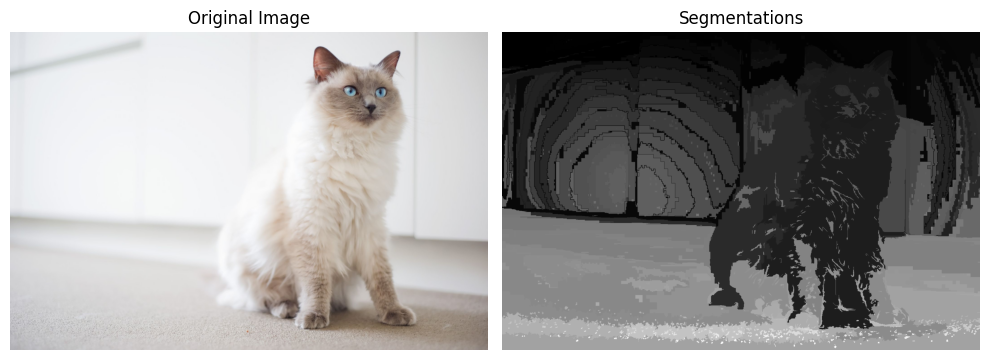

In [8]:
subplots([img_arr, segments], titles=['Original Image', 'Segmentations'], sz=10, nc=2)

## RoI from selective search algorithm

In [9]:
image_label, regions = selectivesearch.selective_search(img_arr, scale=200, min_size=100)

/usr/local/lib/python3.10/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [10]:
image_label.shape

(1412, 2122, 4)

In [11]:
len(regions)

901

In [12]:
regions[0]

{'rect': (0, 0, 223, 152), 'size': 18012, 'labels': [np.float64(0.0)]}

In [13]:
IMAGE_AREA = np.prod(img_arr.shape[:2])
IMAGE_AREA

np.int64(2996264)

In [14]:
candidate_boxes = []
for reg in regions:
    if reg['rect'] in candidate_boxes:
        continue
    if reg['size'] < (0.05 * IMAGE_AREA):
        continue
    if reg['size'] > (1.0 * IMAGE_AREA):
        continue
    candidate_boxes.append(reg['rect'])

In [15]:
candidate_boxes

[(1128, 159, 669, 1162),
 (56, 231, 1332, 1000),
 (0, 1124, 2121, 287),
 (592, 321, 462, 508),
 (145, 209, 445, 599),
 (592, 321, 554, 508),
 (145, 209, 637, 599),
 (128, 0, 935, 614),
 (145, 209, 1001, 620),
 (65, 0, 998, 790),
 (0, 945, 1009, 335),
 (1760, 0, 335, 911),
 (0, 991, 1426, 398),
 (65, 0, 1458, 790),
 (1760, 0, 361, 911),
 (0, 0, 1523, 790),
 (1257, 880, 864, 495),
 (0, 880, 2121, 531),
 (1128, 159, 993, 1162),
 (0, 32, 1388, 1199),
 (1760, 0, 361, 917),
 (0, 823, 1009, 457),
 (1369, 0, 752, 917),
 (1102, 159, 1019, 1162),
 (1102, 56, 1019, 1265),
 (0, 56, 2121, 1355),
 (0, 0, 1523, 1231),
 (0, 0, 1523, 1280),
 (0, 0, 2121, 1280),
 (0, 0, 2121, 1411)]

In [59]:
def extract_candidate_boxes(img_arr):
    _, regions = selectivesearch.selective_search(img_arr, scale=200, min_size=100)
    img_area = np.prod(img_arr.shape[:2])
    candidate_boxes = []
    for reg in regions:
        if reg['rect'] in candidate_boxes:
            continue
        if reg['size'] < (0.05 * img_area):
            continue
        if reg['size'] > (1.0 * img_area):
            continue
        candidate_boxes.append(reg['rect'])
    return candidate_boxes

In [60]:
candidate_boxes = extract_candidate_boxes(img_arr)
candidate_boxes

[(1128, 159, 669, 1162),
 (56, 231, 1332, 1000),
 (0, 1124, 2121, 287),
 (592, 321, 462, 508),
 (145, 209, 445, 599),
 (592, 321, 554, 508),
 (145, 209, 637, 599),
 (128, 0, 935, 614),
 (145, 209, 1001, 620),
 (65, 0, 998, 790),
 (0, 945, 1009, 335),
 (1760, 0, 335, 911),
 (0, 991, 1426, 398),
 (65, 0, 1458, 790),
 (1760, 0, 361, 911),
 (0, 0, 1523, 790),
 (1257, 880, 864, 495),
 (0, 880, 2121, 531),
 (1128, 159, 993, 1162),
 (0, 32, 1388, 1199),
 (1760, 0, 361, 917),
 (0, 823, 1009, 457),
 (1369, 0, 752, 917),
 (1102, 159, 1019, 1162),
 (1102, 56, 1019, 1265),
 (0, 56, 2121, 1355),
 (0, 0, 1523, 1231),
 (0, 0, 1523, 1280),
 (0, 0, 2121, 1280),
 (0, 0, 2121, 1411)]

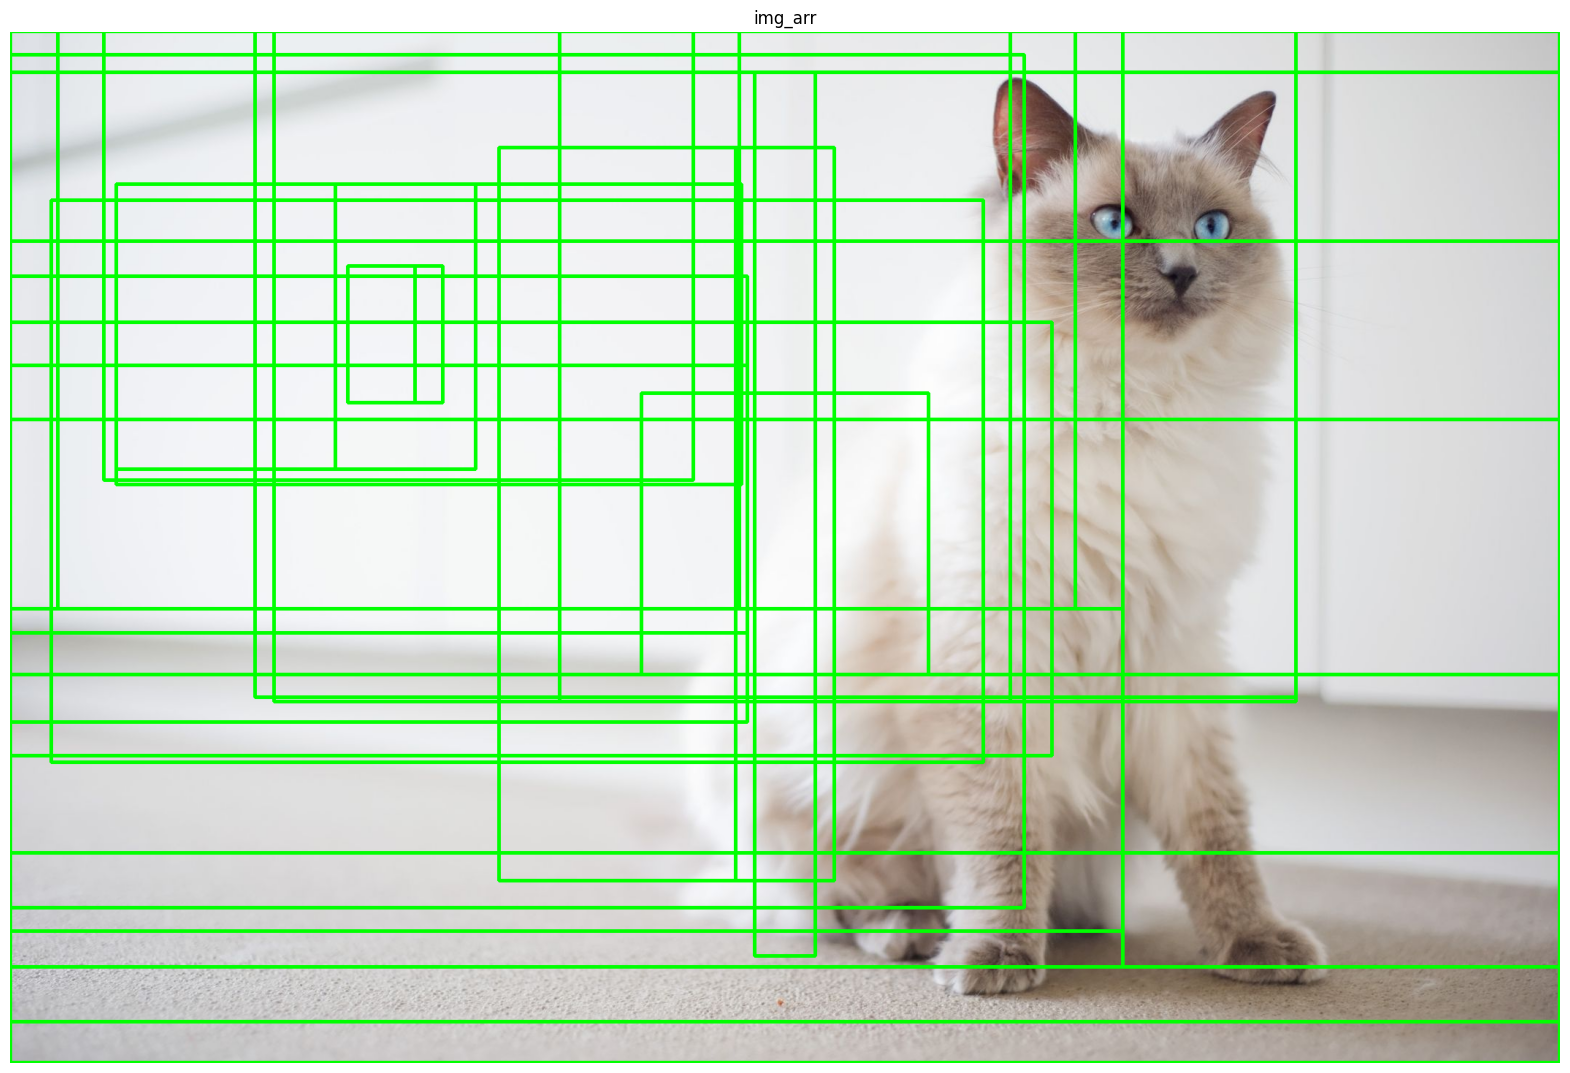

In [25]:
from torch_snippets import show
show(img_arr, bbs=candidate_boxes)

## Explode IoU

Where there is overlapping

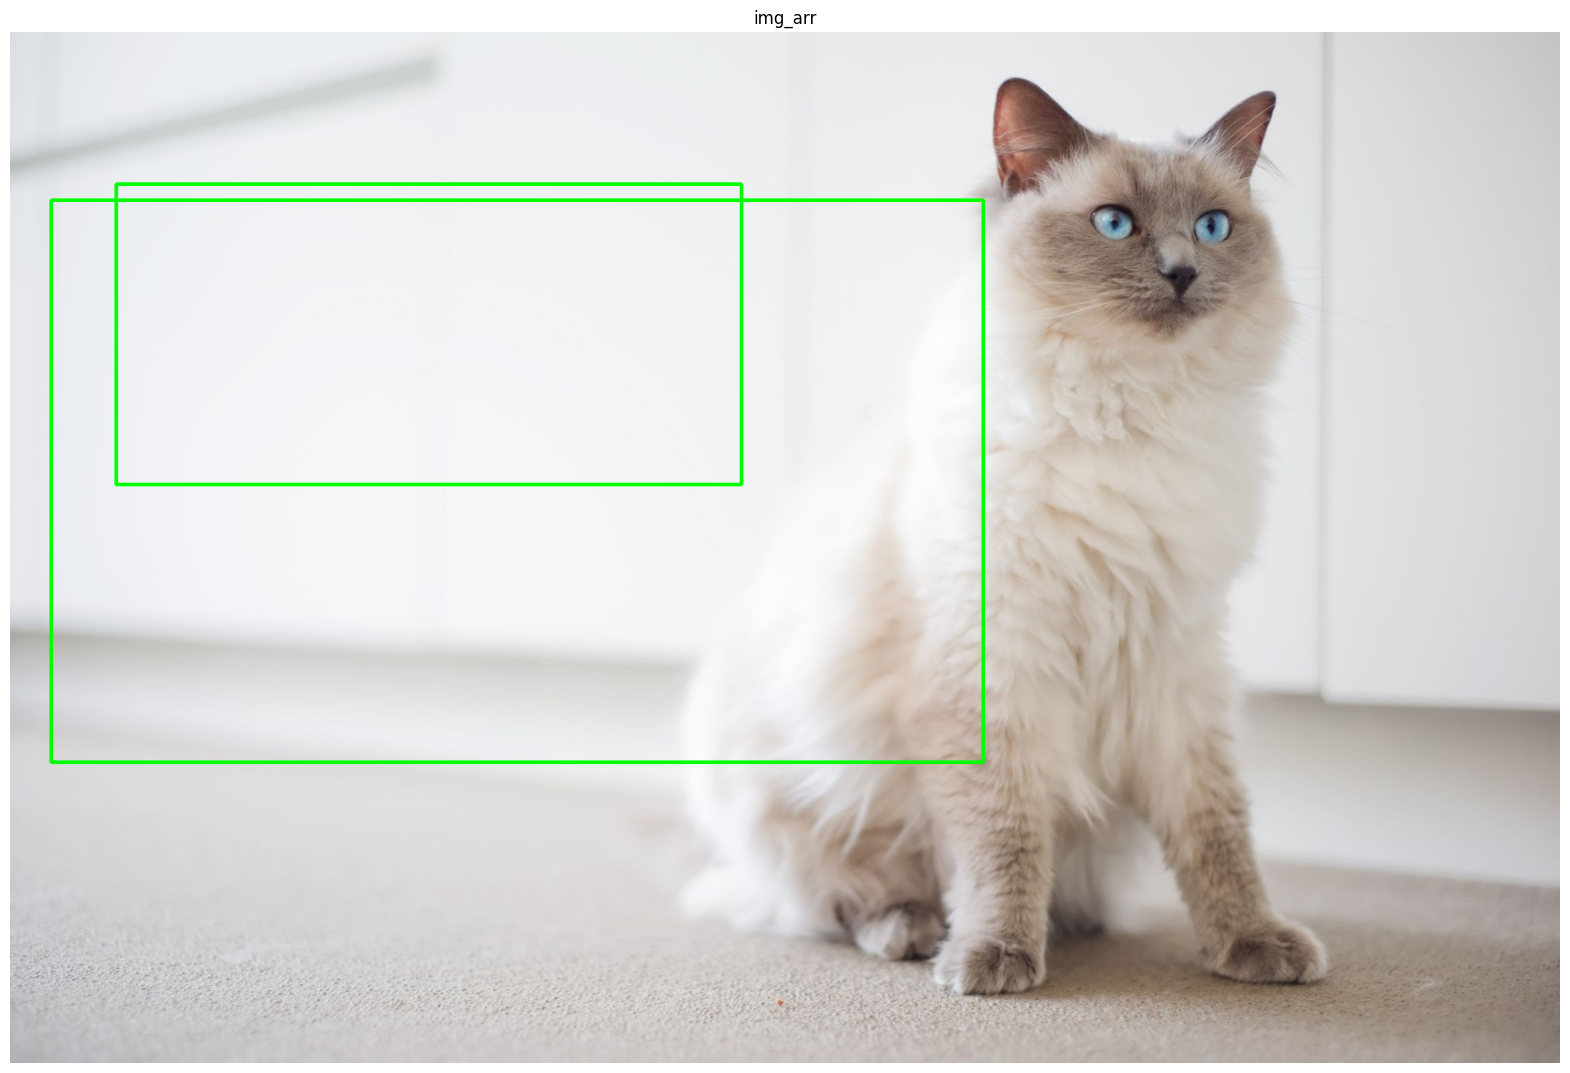

In [26]:
boxA = candidate_boxes[1]
boxB = candidate_boxes[8]
show(img_arr, bbs=[boxA, boxB])

In [44]:
boxA

(56, 231, 1332, 1000)

In [45]:
boxB

(145, 209, 1001, 620)

In [29]:
# findout 

In [46]:
# left side X point
xA = max(boxA[0], boxB[0])
xA

145

In [47]:
# right side X point
xB = min(boxA[2], boxB[2])
xB

1001

In [48]:
# upper Y point
yA = max(boxA[1], boxB[1])
yA

231

In [49]:
# lower Y point
yB = min(boxA[3], boxB[3])
yB

620

In [50]:
width = (xB - xA)
height = (yB - yA)
interArea = width * height
print(f"intersection area is {interArea}")

intersection area is 332984


In [51]:
areaA = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
print(f"area exclude B is {areaA}")

area exclude B is 981244


In [52]:
areaB = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
print(f"area exclude A is {areaB}")

area exclude A is 351816


In [53]:
print(f"IOU is {interArea / float(areaA + areaB - interArea)}")

IOU is 0.3329586951391694


In [54]:
def iou_score(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return np.float64(0.0)
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

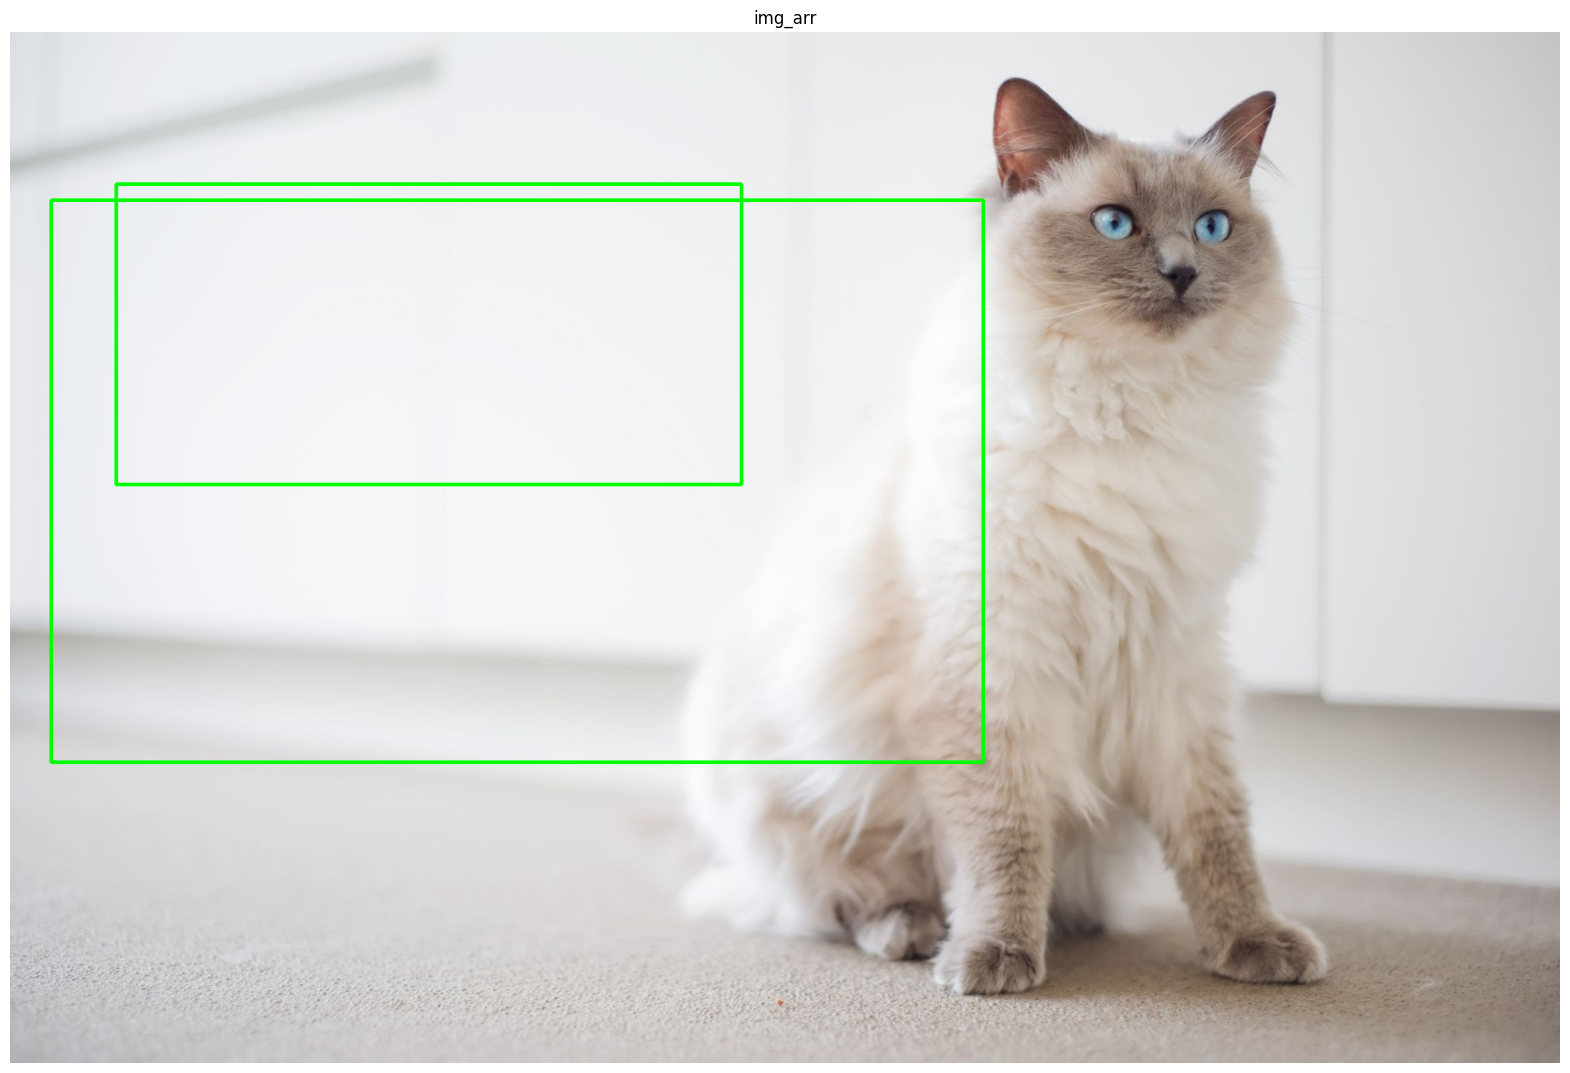

In [55]:
boxA = candidate_boxes[1]
boxB = candidate_boxes[8]
show(img_arr, bbs=[boxA, boxB])

In [56]:
print(f"IOU is {iou_score(boxA, boxB, epsilon=1e-5)}")

IOU is 0.3329586951358401


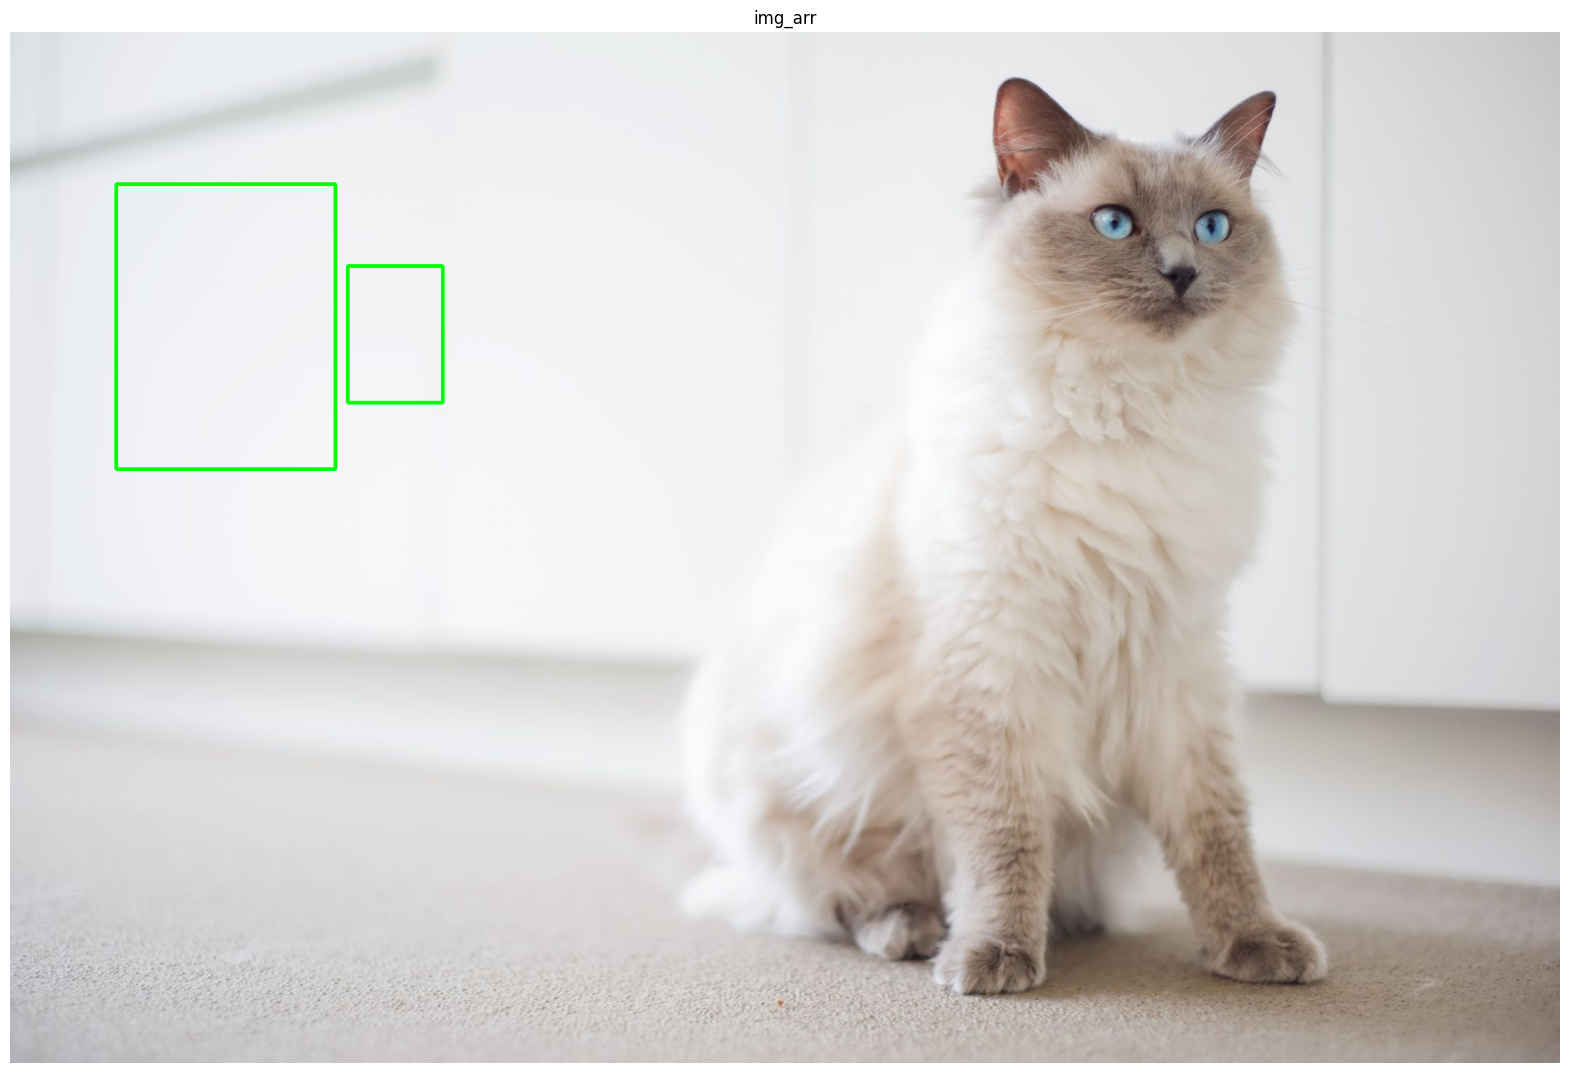

In [57]:
boxA = candidate_boxes[3]
boxB = candidate_boxes[4]
show(img_arr, bbs=[boxA, boxB])

In [58]:
print(f"IOU is {iou_score(boxA, boxB, epsilon=1e-5)}")

IOU is 0.0
